##### Copyright 2018 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Default title text
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Install + Imports

In [1]:
!pip install --upgrade tf_slim

from google.colab import drive

import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL.Image

import tensorflow.compat.v1 as tf
import tf_slim as slim

# Get slim inception code
# from tf_slim.nets import inception # throws error no attribute 'inception_v4_arg_scope'
if not os.path.exists('models/research/slim'):
  !git clone https://github.com/tensorflow/models/
old_cwd = os.getcwd()
os.chdir('models/research/slim')
from nets import inception
os.chdir(old_cwd)

# Download inceptionv4 checkpoint
!wget http://download.tensorflow.org/models/inception_v4_2016_09_09.tar.gz
!tar -xvzf inception_v4_2016_09_09.tar.gz

     |████████████████████████████████| 358kB 2.7MB/s 
Cloning into 'models'...
remote: Enumerating objects: 42458, done.
remote: Total 42458 (delta 0), reused 0 (delta 0), pack-reused 42458
Receiving objects: 100% (42458/42458), 549.61 MiB | 33.00 MiB/s, done.
Resolving deltas: 100% (28890/28890), done.
--2020-08-26 18:37:40--  http://download.tensorflow.org/models/inception_v4_2016_09_09.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.203.128, 2607:f8b0:400c:c07::80
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.203.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 171177982 (163M) [application/x-tar]
Saving to: ‘inception_v4_2016_09_09.tar.gz’

inception_v4_2016_0 100%[===================>] 163.25M   117MB/s    in 1.4s    

2020-08-26 18:37:41 (117 MB/s) - ‘inception_v4_2016_09_09.tar.gz’ saved [171177982/171177982]

inception_v4.ckpt


## Add path to data and projection weights.

NOTE: Data and weights are [shared in this folder](https://drive.google.com/drive/folders/1dTE0PQTMmbg-H0nMjNSPGBfRqinIfFud?usp=sharing). Add these to your Google Drive by selecting "Add shortcut to Drive" before running these cells.

In [2]:
#@title Connect to Drive (Run this cell once)
drive.mount('/content/gdrive')


Go to this URL in a browser:
https://accounts.google.com/o/oauth2/auth?client_id=1234.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
# Verify folder exists after adding the shared folder to your drive.
!ls gdrive/My\ Drive/cell_embedder_colab

imgs  random_projection


In [4]:
#@title Note: Change path to copy images+weights from Drive. (Run once)
!cp -R gdrive/My\ Drive/cell_embedder_colab* .

## Load images and build model




In [5]:
DATA_DIR = 'cell_embedder_colab/'  # NOTE - You need to set this to the location of the data.
IMAGES_DIR = os.path.join(DATA_DIR, 'imgs/fullres_8bit_png_bbbc025')
RANDOM_PROJECTION_CKPT = os.path.join(
    DATA_DIR, 'random_projection/random_projection.ckpt')
INCEPTION_V4_CKPT = 'inception_v4.ckpt'  # This is downloaded in the installs.

In [6]:
#@title Helper functions
def load_image(file_path):
  with PIL.Image.open(file_path) as im:
    im = np.asarray(im)
    return im

def build_inceptionv4_rand64_tower(inputs, is_training=False):
  """Builds an inceptionv4 rand64 tower starting from image tensor.

  The tower consists of an Inception v4 base, and 1 fully connected layer
  reducing output dim to 64, and a normalization layer. Loss is not included.

  Args:
    inputs: An input dictionary mapping key to a tensor of input images i.e.
      {IMAGE_KEY: 4D tensor of (num, h, w, c)}.
    is_training: (bool) Specifies if it is training phase.

  Returns:
    (tensor) A tensor of embeddings.
    (dict) A dictionary mapping endpoint layer names to activation tensors.
  """
  with slim.arg_scope(inception.inception_v4_arg_scope()):
    _, activations = inception.inception_v4(inputs[IMAGE_KEY],
                                            num_classes=1001,
                                            is_training=is_training)
    net = activations['PreLogitsFlatten']
    with slim.arg_scope([slim.fully_connected], activation_fn=None):
      net = slim.fully_connected(net, 64, scope='fc0')
      activations['fc0'] = net
      net = tf.nn.l2_normalize(net, dim=-1, name='embed_norm')
      net = tf.reshape(net, [-1, 64])
      activations['embed_norm'] = net
  return net, activations

['cell_embedder_colab/imgs/fullres_8bit_png_bbbc025/Stack0000.png', 'cell_embedder_colab/imgs/fullres_8bit_png_bbbc025/Stack0001.png', 'cell_embedder_colab/imgs/fullres_8bit_png_bbbc025/Stack0002.png', 'cell_embedder_colab/imgs/fullres_8bit_png_bbbc025/Stack0003.png', 'cell_embedder_colab/imgs/fullres_8bit_png_bbbc025/Stack0004.png']
(5, 1080, 1080, 1)


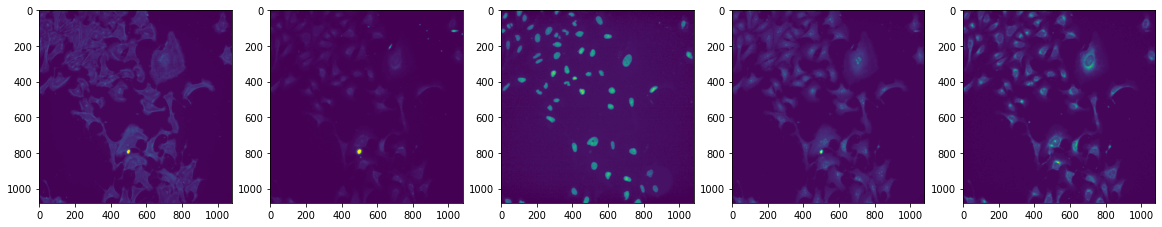

In [7]:
#@title Load Images (sorted by stain names)
image_fnames = sorted(glob.glob('{}/*.png'.format(IMAGES_DIR)))
print(image_fnames)
np_images = []
plt.figure(figsize=(20, 15))
for i, img_fname in enumerate(image_fnames):
  np_images.append(load_image(img_fname))
  plt.subplot(1, len(image_fnames), i+1)
  plt.imshow(np_images[-1])
np_images = np.array(np_images)
np_images = np.expand_dims(np_images, axis=3)
print(np_images.shape)


In [8]:
NUM_STAINS, IMG_HEIGHT, IMG_WIDTH = np_images.shape[0:3]
# The order in which you want the embeddings for each stain. Here embedding for
# img Stack00002.png (DAPI) will come first in the embedding.
STAIN_ORDER = [2,3,4,0,1]
print(NUM_STAINS, IMG_HEIGHT, IMG_WIDTH)

5 1080 1080


In [9]:
#@title Build model and intialize weights. (Run once)

IMAGE_KEY = 'images'
graph = tf.Graph()

with graph.as_default():
  images_ph = tf.placeholder(tf.float32, shape=(None, IMG_HEIGHT, IMG_WIDTH, 1))

  # Resize to 299, 299. This is the input image size for inception.
  images_small = tf.image.resize_images(
      images_ph, [299, 299],
      method=tf.image.ResizeMethod.AREA)
  # Adjust pixel brightness to [0, 1]
  images_small /= 255.0

  # Subtract 0.5 and multiply by 2.0 to keep it within [-1, 1]
  images_small -= 0.5
  images_small *= 2.0
  # Assert image is in [-1, 1]. Add an epsilon on either bound for edge cases.
  epsilon = 0.01
  assert_min = tf.assert_greater_equal(tf.reduce_min(images_small), -(1 + epsilon))
  assert_max = tf.assert_less_equal(tf.reduce_max(images_small), (1 + epsilon))
  with tf.control_dependencies([assert_min, assert_max]):
    images_small = tf.identity(images_small)

  single_stain_images = tf.tile(images_small, [1, 1, 1, 3])
  inputs = {IMAGE_KEY: single_stain_images}
  embed, _ = build_inceptionv4_rand64_tower(inputs, is_training=False)

  assignment_inception_map = {}
  assignment_projection_map = {}

  for v in slim.get_model_variables():
    if v.op.name.startswith('InceptionV4'):
      assignment_inception_map[v.op.name] = v.op.name
    else:
      assignment_projection_map[v.op.name] = v.op.name

  tf.train.init_from_checkpoint(INCEPTION_V4_CKPT, assignment_inception_map)
  tf.train.init_from_checkpoint(RANDOM_PROJECTION_CKPT, assignment_projection_map)

  # We get 1 embedding for each stain. Concatenate the stain embeddings
  # to get 1 embedding for the entire image. This will be of dimension
  # size_of_embedding (64) x num_stains.
  single_stain_embeds = tf.split(embed, NUM_STAINS)
  stain_concat_embed = tf.concat(single_stain_embeds, 1)

  sess = tf.Session(graph=graph)
  saver = tf.train.Saver()
  init_op = tf.global_variables_initializer()
  sess.run(init_op)

def get_ordered_embeddings(input_imgs, images_ph=images_ph,sess=sess):
  stain_embeds, concat_embed = sess.run([single_stain_embeds,
                                         stain_concat_embed],
                                         feed_dict={images_ph: input_imgs})
  ordered_tf_embeds = np.concatenate([stain_embeds[i] for i in STAIN_ORDER],
                                     axis=1)
  return ordered_tf_embeds

Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.Flatten instead.
Instructions for updating:
dim is deprecated, use axis instead


## Get Embeddings

[-0.03725917 -0.04305332 -0.0187017  -0.0922543  -0.03270548 -0.3268842
 -0.09732732 -0.05538129 -0.06901038  0.07042941]


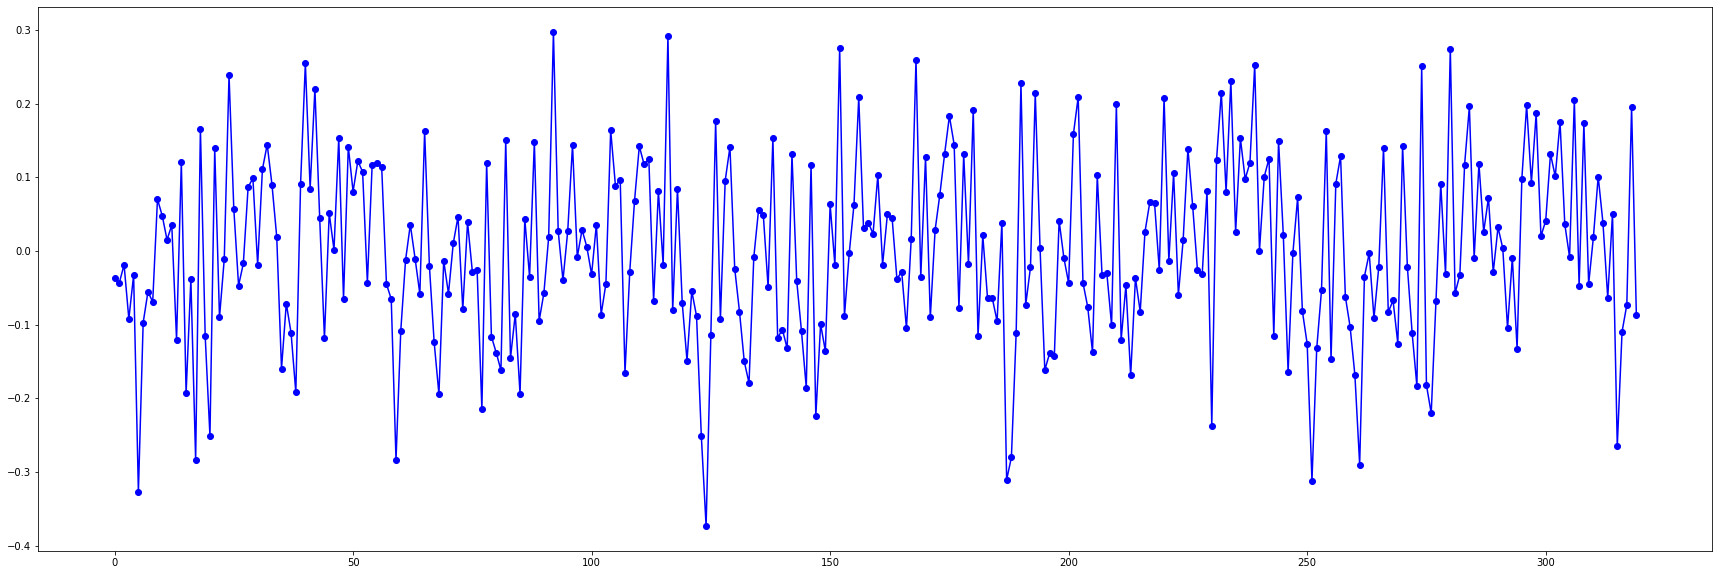

In [10]:
embeds = get_ordered_embeddings(np_images)
print(embeds[0][:10])
plt.figure(figsize=(30,10))
plt.plot(embeds.T, 'b-o')